# Capstone Project - Rajini Gurijala

#### Employee Turnover Data Analysis ####

In this Capstone project, I will be performing data analysis through different process flows outlined in the datascience course, which includes statistical inference and exploratory data analysis. The main goal is to understand and analyze the reasoning behind employee turnover.

Recognizing and understanding what factors that were associated with employee turnover will allow companies to to take corrective actions to minimize turnover and thus increase employee productivity and growth. 


Taking a typical data science framework **“OSEMN”** approach, I will be performing my data exploratory analysis using the first 3 steps. The last 2 steps to **Model and Intepret is out of scope** for this project report.

   1. Obtaining the data that we need from available data sources.
   
   2. Scrubbing or cleaning the data which includes data manipulation of missing/invalid data.
   
   3. Exploring the data by looking for any outliers and understanding the relationship each explanatory variable has with the response variable resides here and we can do this with a correlation matrix. 
      The term “Feature” used in Machine Learning or Modeling, is the data features that help us to identify the characteristics that represent the data. For example, “Name”, “Age”, “Gender” are typical features of members or employees dataset.
   
   4. Modeling the data to give us our predictive power on whether an employee will leave.
  
 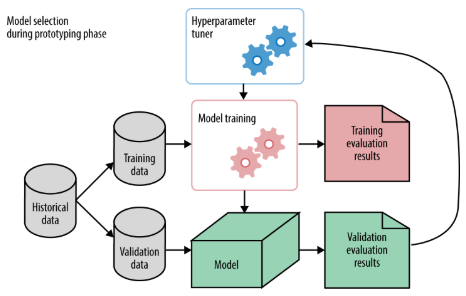
   
   5. Interpreting the data is last step. The predictive power of a model lies in its ability to generalise. 
       With all the results and analysis of the data, what conclusions are made? What factors contributed the most to the employee turnover? What relationship of variables were found?

#### Introduction ####
HR data can be hard to come by, and HR professionals generally lag behind with respect to analytics and data visualization competency. The data set that I will be analyzing for my first capstone project, was created and made available by Dr. Rich Huebner and Dr. Carla Patalano. This data set is used in one of the **Graduate MSHRM courses called HR Metrics and Analytics, at New England College of Business**. 

The csv file comes from kaggle.com and markets itself as the most complete database for employee data. There are multiple worksheets within the Excel workbook. These include:

   - Core data set
   - HR data set with additional fields
   - Production staff
   - Salaries
   - Recruiting sources

The Excel workbook revolves around a **fictitious company, called Dental Magic**, and the core data set contains names, DOBs, age, gender, marital status, date of hire, reasons for termination, department, whether they are active or terminated, position title, pay rate, manager name, and performance score.

#### Analytics Questions ####
1. Are there any relationship between the **turnover and the other employee features** such as Gender, Race, Age etc.?

2. What feature are moderately or highly correlated to the Turnover feature? Perform **Null Vs. Alternate Hypothesis** for the highly/moderately correlated feature.

3. How does **employee pay rate** impact the turnover? Are people with lower pay leaving the company?


#### Step 1: Obtaining the Data ####

In [153]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import nbconvert

import scipy.stats as stats
sns.set()
%matplotlib inline  

#Read the HR data analytics csv file and store our dataset into a dataframe called "df"
df = pd.read_csv('HRDataset_v9.csv')
    

#### Step 2: Scrubbing the Data ####
Typically, cleaning the data requires a lot of work and can be a very tedious procedure. This dataset from Kaggle is clean and contains no missing values with the exception of **Termination Date** column. This indicates that the employee is Active if the termination date is null or blank. 

However, I will still examine the dataset to make sure that everything else is readable and that the observation values match the feature names appropriately.

In [154]:
# Check to see if there are any missing values in our data set
# df.isnull().any() or df.isnull().sum()
df.isnull().any()

# Check for duplicate observations
df.duplicated().sum()

# Get a quick overview of what we are dealing with in our dataset
df.head()

#Insert new columns Turnover and Attrition at the end of the file with blank data.
df.insert(28,'Turnover',None)
df.insert(29,'Attrition',None)
df.insert(30,'Pay Range',None)
df.insert(31,'Age Range',None)


#Calculate the turnover and the attrition based on the Reason for Term
#df[col = df[col].apply(lambda x: 0 if x == 'No' else 1)
df['Turnover'] = df['Reason For Term'].str[:3].apply(lambda x: 0 if x == 'N/A' else 1)
df['Attrition'] = df['Reason For Term'].str[:3].apply(lambda x: "No Turnover" if x == 'N/A' else "Turnover")


# Move the reponse variable "turnover" to the front of the table
front = df['Turnover']
df.drop(labels=['Turnover'], axis=1,inplace = True)
df.insert(0, 'Turnover', front)
df.head()

# Put the pay rates into bins
bins = [10, 25, 40, 55, 70, 85]
group_names = ['10-25', '25-40', '40-55', '55-70', '70-85']
df["Pay Range"] = pd.cut(df["Pay Rate"], bins, labels = group_names)

# Put the age into bins
bins = [21, 25, 35, 45, 55, 70]
group_names = ['(18-25)', '(26-35)', '(36-45)', '(46-55)', '(56-70)']
df['Age Range'] = pd.cut(df['Age'], bins, labels = group_names)


In [155]:
# Drop unnecessary attibutes and rename the dataframe
df2 = df.drop(labels = ['Employee Number','MarriedID','GenderID','Zip','MaritalStatusID', 'EmpStatus_ID', 'DeptID'], axis = 1)

# Exclude probationary employees from Performance ratings
perf = df[df['Perf_ScoreID'].isin([1,2,3,4,5])]

# Copy dataframe to emp dataframe and categorize the features
emp = df2

# Changing object types to categories
cols = ['Sex', 'MaritalDesc','RaceDesc','CitizenDesc', 'Employment Status', 'Department','Position', 'Employee Source','Reason For Term', 'Performance Score']
for col in cols:
    emp[col] = emp[col].astype('category')
    

###### Python Functions ######
We will create 2 functions - the first one to summarize the data and display in tabular format and the second one to plot the graph for a given feature.

In [156]:
# Create 2 functions for the attribute categories

# Create Attribute Dataframe
def table_attr(x): 
    """
    This function creates dataframe for each attribute in the dataset
    """
    
    attribute = emp.groupby(x).agg({'Turnover':['size', 'sum', 'mean']})
    attribute.columns = [' '.join(col).strip() for col in attribute.columns.values]
    attribute = attribute.reset_index()
    attribute['Turnover mean'] = attribute['Turnover mean']*100
    attribute.columns = [x, 'Total Employee ', 'Turnover Count', 
                       '% of Turnover in the Relevant Group'] 
    attribute['% of Turnover at Dental Magic'] = (attribute['Turnover Count'] / 102)*100
    #102 represents number of termed employees in the data set
        
    return attribute
# Create graph for each attribute to compare its turnover in the company 

def graph_attr(x, y = 'bar', z = 0):
    """
    This function creates graph for each attribute in the dataset
    """
    
    attribute = emp.groupby(x).agg({'Turnover':['size', 'sum', 'mean']})
    attribute.columns = [' '.join(col).strip() for col in attribute.columns.values]
    attribute = attribute.reset_index()
    attribute['Turnover mean'] = attribute['Turnover mean']*100
    attribute.columns = [x, 'Total Employee', 'Turnover Count', 
                       '% of Turnover in the Relevant Group'] 
    
    fig0, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    attribute.set_index(attribute[x], drop=True, inplace=True)
    attribute['Total Employee'].plot(kind = y, stacked = True, ax = ax1, 
                                   colormap = 'winter', rot = z)
    attribute['% of Turnover in the Relevant Group'].plot(use_index = False, 
                                                         kind = 'line', ax = ax2, colormap='Spectral')
    plt.title('Turnover compared to' + " " + x  + " " + "Groups")
    plt.xticks(rotation='vertical')
    ax1.set_xlabel(x)
    ax1.yaxis.label.set_color('blue')
    ax1.set_ylabel("Total Employee")
    ax2.set_ylabel("Turnover Percentage in the Relevant Group")
    ax2.yaxis.label.set_color('red')
        
    plt.tight_layout()
    plt.show()

#### Step 3: Exploring the Data ####

##### Statistical Overview #####
- About 310 employee observations and 25 features
- The company had a turnover rate of about 33%

In [157]:
# Shape of data i.e. number of rows and number of columns
df2.shape

# The dataset contains 25 columns and 310 observations

(310, 25)

In [158]:
# Check the type of our features. 
df2.dtypes

# NOTE: When performing cross validation, its important to maintain this turnover ratio
turnover_rate = df2.Turnover.value_counts() / len(df2)
print("Turnover Rate %")
print(turnover_rate*100)

# Looks like about 67% of employees stayed and 33% of employees left. 

Turnover Rate %
0    67.096774
1    32.903226
Name: Turnover, dtype: float64


In [159]:
# Display the statistical overview of the employees
df2.describe()

# Overview of summary (Turnover V.S. Non-turnover)
turnover_Summary = df2.groupby('Turnover')
turnover_Summary.mean()


,Perf_ScoreID,Age,Pay Rate,Days Employed
Turnover,,,,
0,3.533654,38.230769,33.357308,1552.697115
1,3.303922,40.166667,27.058529,772.784314


In [160]:
# Display the statistical overview of the employees
df2.describe()

# Overview of summary (Turnover V.S. Non-turnover)
turnover_Summary = df2.groupby('Turnover')
turnover_Summary.mean()

,Perf_ScoreID,Age,Pay Rate,Days Employed
Turnover,,,,
0,3.533654,38.230769,33.357308,1552.697115
1,3.303922,40.166667,27.058529,772.784314


#### Feature/Variable Relationships: ####

Here we will take a look at how variables relate to each other. There are various methods/visualizations available to perform the analysis. I will use correlation matrix (heat map) method for this purpose. 

Correlation means association - more precisely it is a measure of the extent to which two variables are related. There are three possible results of a correlational study: a positive correlation, a negative correlation, and no correlation.
- A positive correlation is a relationship between two variables in which both variables either increase or decrease at the same time. An example would be employee pay and satisfaction. Employees with higher pay tend to have higher satisfaction.
- A negative correlation is a relationship between two variables in which an increase in one variable is associated with a decrease in the other. An example would be employee attrition is higher if the pay is low.
- A zero correlation exists when there is no relationship between two variables. For example, there is no relationship between the employee's zip code and gender.
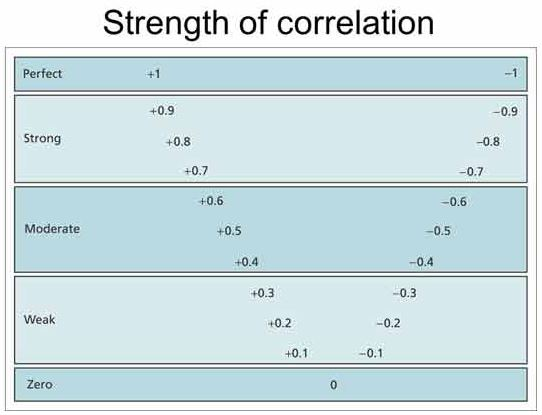

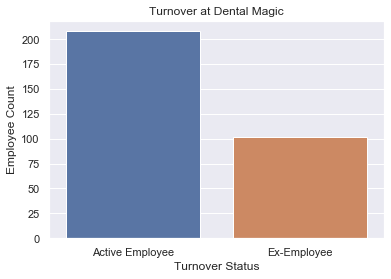

Active Employee    208
Ex-Employee        102
Name: Turnover, dtype: int64

In [161]:
trgt = df2['Turnover'].apply(lambda x: 'Active Employee' if x == 0 else 'Ex-Employee')
sns.countplot(trgt)
plt.title('Turnover at Dental Magic')
plt.xlabel('Turnover Status')
plt.ylabel('Employee Count')
plt.show()
trgt.value_counts()

##### Features:
We have 23 features consisting of both categorical as well as the numerical features. Response variable is 'Turnover' of the employees which can 1 and 0 (representing 'Yes' and 'No' respectively). This is what we will predict.

Now, I will try to analyze visually the trends in how and why employees are quitting their jobs. For that, I will deep dive into the details about features and their relationships between each other.

,Turnover,Perf_ScoreID,Age,Pay Rate,Days Employed
Turnover,1.000000,-0.046633,0.102110,-0.192695,-0.476995
Perf_ScoreID,-0.046633,1.000000,-0.105321,-0.059799,-0.235058
Age,0.102110,-0.105321,1.000000,0.017469,0.017666
Pay Rate,-0.192695,-0.059799,0.017469,1.000000,0.044320
Days Employed,-0.476995,-0.235058,0.017666,0.044320,1.000000


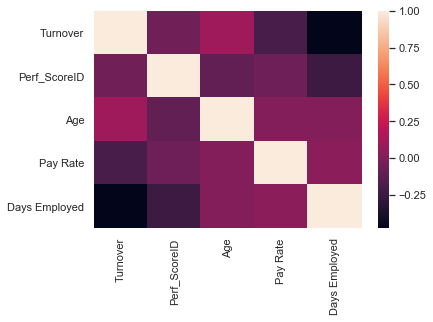

In [162]:
# Correlation Matrix & Heatmap

corr = df2.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

##### From the heatmap, there is a moderately negative(-) correlation between, turnover and days employed. ####

Moderate Negatively Correlated Feature:
Days Employed vs Turnover: -0.476995

We can assume that people tend to leave a company more in their early years of employment. Once they have more than 2 years of service, they tend to stick with the company.


#### Statistical Test for Correlation ####

##### One-Sample T-Test (Measuring Days Employed) #####

A one-sample t-test checks whether a sample mean differs from the population mean. Since days employed has the moderate to highest correlation with our dependent variable turnover, let's test to see whether the average days employed of employees that had a turnover differs from the those that had no turnover.

Hypothesis Testing: Is there significant difference in the means of days employed between the employees who had a turnover and the employees who had no turnover?

###### Null and Alternate Hypothesis: ######

Null Hypothesis: The null hypothesis would be that there is no difference in days employed between employees who had turnover and those who did not.

$$H_0: \hat p_{days\_employed\_turnover} - \hat p_{days\_employed\_no\_turnover} = 0$$

Alternative Hypothesis: The alternative hypothesis would be that there is a difference in days employed between employees who had turnover and those who did not.
$$H_a: {\hat p_{days\_employed\_turnover}} - {\hat p_{days\_employed\_no\_turnover}} \neq 0$$
    
Significance Level: 95% Confidence:

##### Statistical Test for Correlation  #####

Conducting the T-Test

Let's assume that it is Normal Distribution (Parameteric Distribution) and conduct a t-test at 95% confidence level and see if it correctly rejects the null hypothesis that the sample comes from the same distribution as the employee population. To conduct a one sample t-test, we can use the stats.ttest_1samp() function:


In [163]:
 
# Let's compare the means of our employee turnover days employed against
# the employee population days employed
emp_population = df2['Days Employed'][df2['Turnover'] == 0].mean()
emp_turnover_days_employed = df2[df2['Turnover']==1]['Days Employed'].mean()

print( 'The mean Days Employed for the employee population with no turnover is: ' + str(emp_population))
print( 'The mean Days Employed for the employees that had a turnover is: ' + str(emp_turnover_days_employed))

# Let's conduct a t-test at 95% confidence level and see if it correctly rejects the 
# null hypothesis that the sample comes from the same distribution as the employee population.
# To conduct a one sample t-test, we can use the stats.ttest_1samp() function:

import scipy.stats as stats
stats.ttest_1samp(a=  df2[df2['Turnover']==1]['Days Employed'], # Sample of Employee who had a Turnover
                                     popmean = emp_population)  # Employee who had No Turnover.Mean



The mean Days Employed for the employee population with no turnover is: 1552.6971153846155
The mean Days Employed for the employees that had a turnover is: 772.7843137254902


Ttest_1sampResult(statistic=-12.893261698934086, pvalue=4.563320428865964e-23)

##### T-Test Result  #####

The test result shows the test statistic "t" is equal to -12.89. This test statistic tells us how much the sample mean deviates from the null hypothesis. 

If the t-statistic lies outside the quantiles of the t-distribution corresponding to our confidence level and degrees of freedom, we reject the null hypothesis. We can check the quantiles with stats.t.ppf():

##### T-Test Quantile  #####

If the t-statistic value we calculated above (-12.89) is outside the quantiles, then we can reject the null hypothesis.

In [164]:
degree_freedom = len(df2[df2['Turnover']==1])

LQ = stats.t.ppf(0.025,degree_freedom)  # Left Quartile

RQ = stats.t.ppf(0.975,degree_freedom)  # Right Quartile

print ('The t-distribution left quartile range is: ' + str(LQ))
print ('The t-distribution right quartile range is: ' + str(RQ))


The t-distribution left quartile range is: -1.9834952584959407
The t-distribution right quartile range is: 1.98349525849594


##### One-Sample T-Test Summary #####

- T-Test score is outside the quantiles -1.98 and +1.98
- P-value is lower than confidence level of 5%

The super low P-value of 0.00_ at a 5% confidence level is a good indicator to reject the null hypothesis.

But this does not neccessarily mean that there is practical significance. We would have to conduct more experiments or maybe collect more data about the employees in order to come up with a more accurate finding.

Let us check if the distribution is normal for Days Employed with Turnover Vs. With No Turnover. 

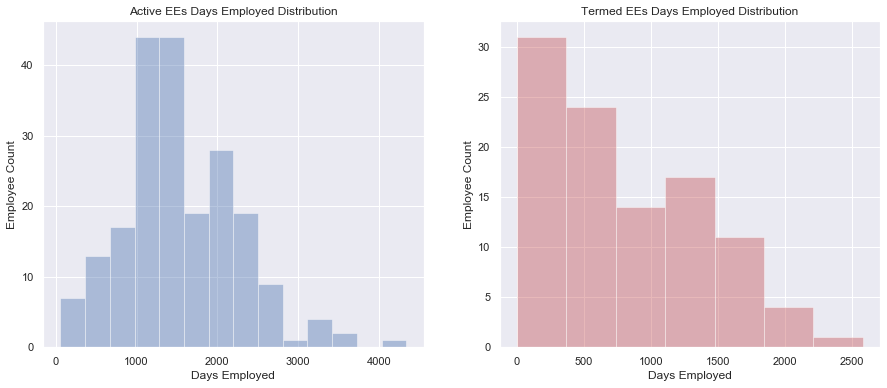

In [165]:
# Set up the matplotlib figure
f, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Graph Active Employee Days Employed
sns.distplot((df2['Days Employed'][df2['Turnover'] == 0]), kde=False, color="b", ax=axes[0]).set_title('Active EEs Days Employed Distribution')
axes[0].set_ylabel('Employee Count')

# Graph Termed Employee Days Employed
sns.distplot((df2['Days Employed'][df2['Turnover'] == 1]), kde=False, color="r", ax=axes[1]).set_title('Termed EEs Days Employed Distribution')
axes[1].set_ylabel('Employee Count')
plt.show()

##### Mann-Whitney U-Test #####
As per the graphs above, the distribution for days employed is not **normal** for the 2 groups of turnover, so lets choose the Non-Parametric Analysis i.e. Mann-Whitney U-Test

In [166]:
# Create two groups of data

active = df2[df2['Turnover']==0]['Days Employed']
term = df2[df2['Turnover']==1]['Days Employed']

# Calculate u and probability of a difference

u_statistic, pVal = stats.mannwhitneyu(active, term)

print(u_statistic)
print(round(pVal,21))


4364.0
1.8683e-17


##### U-Test Summary #####

Based on the statistical analysis, both U-Test and T-Test Score are outside the quantiles and have low P-value implying that there seems to be some significant difference between the days employed of employees who had a turnover and the entire employee population. Therefore we can reject the null hypothesis.

##### Hypothesis Testing (Examining Turnover in Gender throughout the company)

In [167]:
# Sex Group & Turnover Table
table_attr(x = 'Sex')

,Sex,Total Employee,Turnover Count,% of Turnover in the Relevant Group,% of Turnover at Dental Magic
0,Female,177,59,33.333333,57.843137
1,Male,133,43,32.330827,42.156863


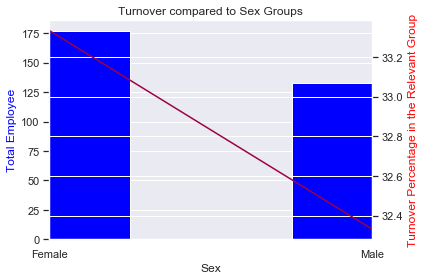

In [168]:
# Turnover Compared to Sex Group Graph
graph_attr(x = 'Sex')

###### Female employees are more likely to leave Dental Magic than Male employees. #####

Since the turnover rate for two groups is compared, a two-proportion z-test is appropriate. **Central Limit Theorem (CLT)** states that regardless of the population, the distribution of sample averages tends to be normal. This holds for sample sizes greater than or equal to 30. Since the size of the data is big enough and 'female' and 'male' turnover randomly to the resumes when presented to the employer, CLT could be applied here assuming that samples are respresentative of the population.

###### Null and Alternate Hypothesis: ######

As observed above, it is obvious that female turnover is more than male's turnover but is the difference significant? Here is the important point to define the null and alternative hypothesis: 

In the context of provided information, the alternative hypothesis assumes that male turnover is pervasive enough to be a factor in turnover throughout the company.

Null Hypothesis: There is no difference in the proportion of turnover for male and female employees in the company.

$$H_0: \hat p_{female\_turnover} - \hat p_{male\_turnover} = 0$$

Alternative Hypothesis: There is a significant difference in the proportion of turnover for male and female employees in the company.

$$H_a: {\hat p_{female\_turnover}} - {\hat p_{male\_turnover}} \neq 0$$
Significance Level: 95% Confidence:

###### Performing  Z-Test

In [169]:
# Assign female and  male into variables
female = df2[df2['Sex'] == 'Female']
male = df2[df2['Sex'] == 'Male']

# Find the mean for female and male employees turnover
female_turnover_mean = female['Turnover'].mean()
male_turnover_mean = male['Turnover'].mean()
print ('Female Turnover mean: {}'.format(female_turnover_mean))
print ('Male Turnover mean: {}'.format(male_turnover_mean))

# Find the difference of female and male employees turnover
diff_mean = female_turnover_mean - male_turnover_mean
print ('Difference of mean between female and male employees turnover: {}'.format(diff_mean))

Female Turnover mean: 0.3333333333333333
Male Turnover mean: 0.3233082706766917
Difference of mean between female and male employees turnover: 0.010025062656641603


In [170]:
# Compute z-score
male_turnover = np.sum(male['Turnover'])
female_turnover = np.sum(female['Turnover'])
male_ln = len(male)
female_ln = len(female) 
phat = (male_turnover + female_turnover) / (male_ln + female_ln)
z = (diff_mean) / np.sqrt(phat * (1 - phat) * (( 1/ float(male_ln)) + (1/float(female_ln))))
print ('z score:{}'.format(z))

# Compute p-value
p = stats.norm.cdf(-z)*2
print ('p-value:{}'.format(p))

# Compute margin of error
moe = 1.96 * np.sqrt(phat * (1 - phat) * (( 1/ float(male_ln)) + (1/float(female_ln))))
print("Margin of Error: {}".format(moe))

# Compute confidence interval
ci = diff_mean + np.array([-1, 1]) * moe
print("Confidence interval: {}".format(ci))

z score:0.18592964618759225
p-value:0.8524999332504953
Margin of Error: 0.10568041842661667
Confidence interval: [-0.09565536  0.11570548]


##### Conclusion #####
Based on the Z-Test p-value is above the significance level (0.05). So, I fail to reject the null hypothesis. We can conclude that there is no enough evidence to reject the assumption of no difference in the proportion of turnover for male and female employees in the company. 

##### Data Visualization #####

Let's perform the data visualization on some of the employee's features.


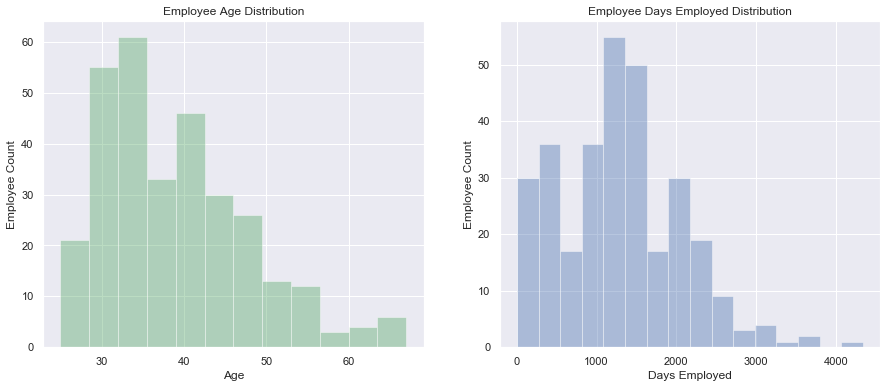

In [171]:
# Set up the matplotlib figure
f, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Graph Employee Age
sns.distplot(sal['Age'], kde=False, color="g", ax=axes[0]).set_title('Employee Age Distribution')
axes[0].set_ylabel('Employee Count')

# Graph Employee Days Employed
sns.distplot(sal['Days Employed'], kde=False, color="b", ax=axes[1]).set_title('Employee Days Employed Distribution')
axes[1].set_ylabel('Employee Count')
plt.show()

#####  Pay Rate Vs. Turnover #####

In [172]:
# Salary Group & Turnover Table
table_attr('Pay Range')

,Pay Range,Total Employee,Turnover Count,% of Turnover in the Relevant Group,% of Turnover at Dental Magic
0,10-25,171,67,39.181287,65.686275
1,25-40,48,16,33.333333,15.686275
2,40-55,64,15,23.437500,14.705882
3,55-70,26,4,15.384615,3.921569
4,70-85,1,0,0.000000,0.000000


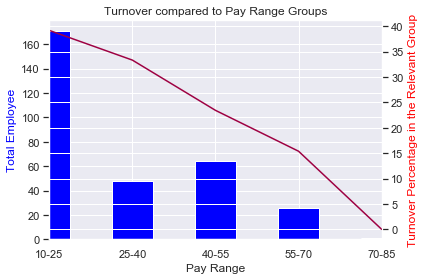

In [173]:
# Turnover Compared to Salary Group Graph
graph_attr('Pay Range')

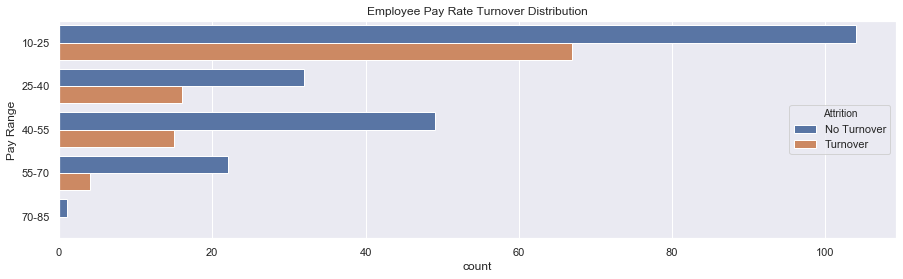

In [174]:
f, ax = plt.subplots(figsize=(15, 4))

sns.countplot(y="Pay Range", hue='Attrition', data=df).set_title('Employee Pay Rate Turnover Distribution');


##### Summary: 
The employees within pay range between **$10-25 dollars per hour**, have high turnover and is composed of the 66% of company's turnover and 39% within its own pay rate group level. As the pay rate increases, it is observed that there is a decrease in turnover. This is not unusual. As you see:
   - Majority of employees who left either had low or medium salary.
   - Barely any employees left with high salary
   - Employees with low to average salaries tend to leave the company.

##### Department Vs. Turnover #####

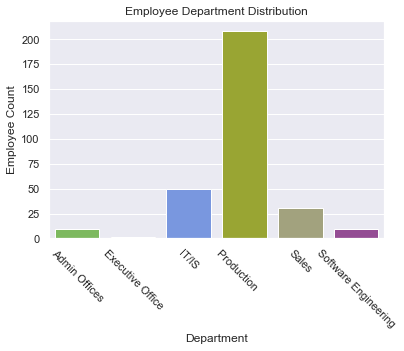

In [175]:
# Types of colors
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0']

# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='Department', data=df2, palette=color_types).set_title('Employee Department Distribution');
 
# Rotate x-labels
plt.xticks(rotation=-45)

# Set Y Label
plt.ylabel('Employee Count')
plt.show()

In [176]:
# Department Group & Turnover Table
table_attr('Department')

,Department,Total Employee,Turnover Count,% of Turnover in the Relevant Group,% of Turnover at Dental Magic
0,Admin Offices,10,2,20.000000,1.960784
1,Executive Office,1,0,0.000000,0.000000
2,IT/IS,50,10,20.000000,9.803922
3,Production,208,83,39.903846,81.372549
4,Sales,31,4,12.903226,3.921569
5,Software Engineering,10,3,30.000000,2.941176


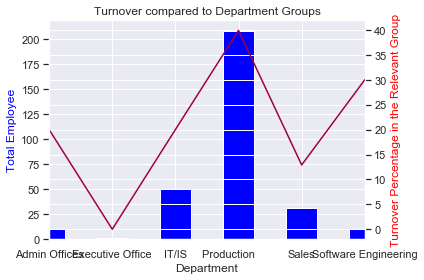

In [177]:
# Turnover Compared to Department Group Graph
graph_attr('Department')

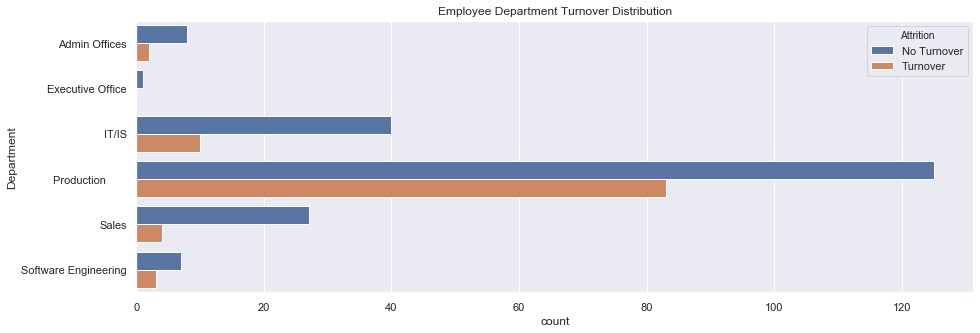

In [178]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y="Department", hue='Attrition', data=df2).set_title('Employee Department Turnover Distribution');

##### Summary: 
There are six departments in the company. **Production Department** has the most turnover in the company. 39.9 % of **Production Department** employees left the organization. In numbers, it is equal to 83, which makes up the 81.4 % of company's turnover. This analysis implies that
   - The Prodution department is the top department to have employee turnover
   - The Executive Office and Admin Offices had low turnover


##### Turnover Vs. Days Employed #####

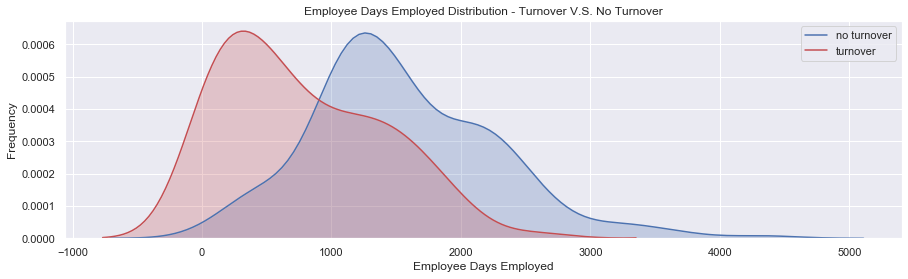

In [179]:
#KDEPlot: Kernel Density Estimate Plot
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df2.loc[(df2['Turnover'] == 0),'Days Employed'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df2.loc[(df2['Turnover'] == 1),'Days Employed'] , color='r',shade=True, label='turnover')
ax.set(xlabel='Employee Days Employed', ylabel='Frequency')
plt.title('Employee Days Employed Distribution - Turnover V.S. No Turnover')
plt.show()

##### Summary: #####
Another bi-modal distribution for employee attrition implies that the:
- Employees who were employed shorter time period (~800 days) tend to leave the company more
- Employees who were employed longer time period (~900 days) tend to stay with the company longer.


In [180]:
# Categorical Plot

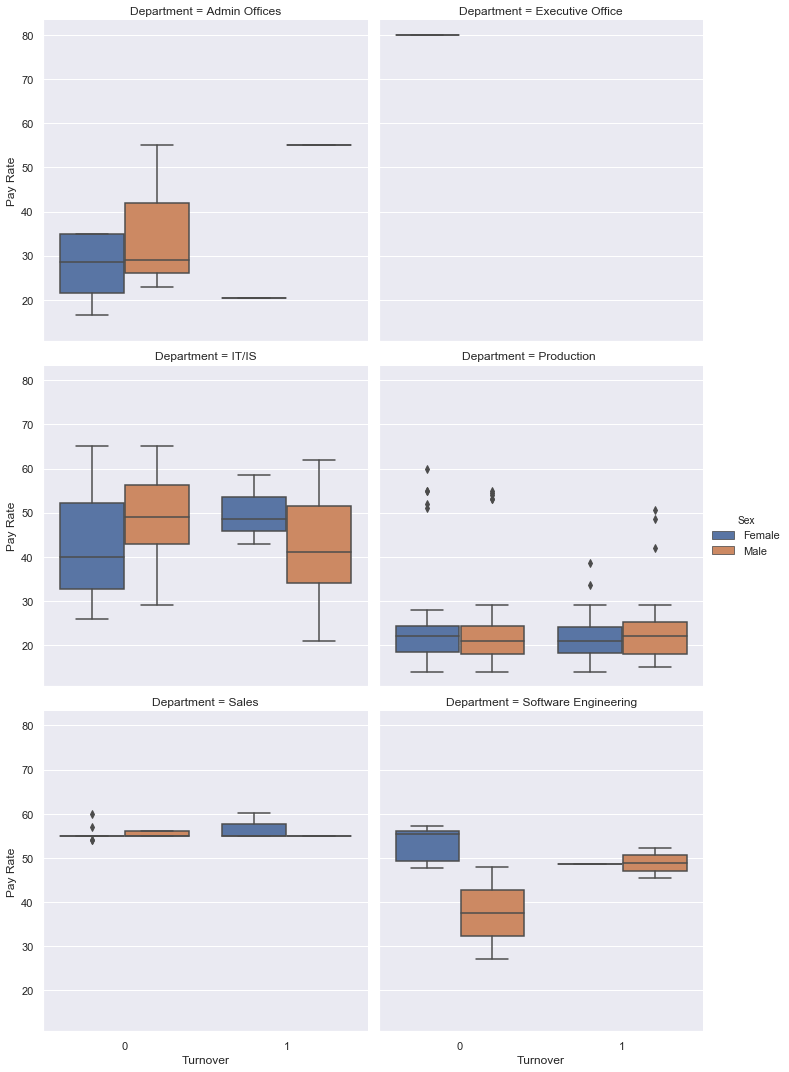

In [181]:
sns.catplot   (x =   'Turnover',     # Categorical
               y =   'Pay Rate',      # Continuous
               hue = 'Sex',    # Categorical
               col = 'Department',
               col_wrap=2,           # Wrap facet after two axes
               kind = 'box',
               data = df)
plt.show()

##### Summary: #####
 - In the Production department female employees pay rate has more outliers than the male employees, however the average pay rate is same for both these groups.
 - In the Admin Offices and and IT/IS departments, the male employees have higher pay rate compared to female employees. 
 - The average pay rate is the same for Admin Offices employees in both these groups, however it is higher for male employees in IT/IS department.
 

##### Age Vs. Turnover #####

In [182]:
# Age Group & Turnover Table
table_attr(x = 'Age Range')

,Age Range,Total Employee,Turnover Count,% of Turnover in the Relevant Group,% of Turnover at Dental Magic
0,(18-25),2,0,0.000000,0.000000
1,(26-35),135,42,31.111111,41.176471
2,(36-45),109,36,33.027523,35.294118
3,(46-55),50,16,32.000000,15.686275
4,(56-70),14,8,57.142857,7.843137


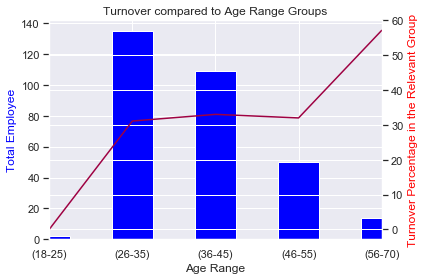

In [183]:
# Turnover Compared to Age Group Graph
graph_attr(x = 'Age Range')

##### Summary #####
If we evaluate overall turnover in the company,  **26-35 age group's turnover number** is the highest comparing to other age groups. In this age group, we have 31.1 % of employee turnover(42 out 135). That makes up approximately 41 % of all turnover in the company (42 out of 102). 

##### Marital Status Vs. Turnover #####

In [184]:
# Marital Group & Turnover Table
table_attr('MaritalDesc')

,MaritalDesc,Total Employee,Turnover Count,% of Turnover in the Relevant Group,% of Turnover at Dental Magic
0,Divorced,30,16,53.333333,15.686275
1,Married,123,45,36.585366,44.117647
2,Separated,12,1,8.333333,0.980392
3,Single,137,36,26.277372,35.294118
4,Widowed,8,4,50.000000,3.921569


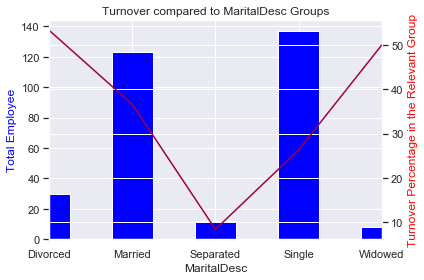

In [185]:
# Turnover Compared to Marital Group Graph
graph_attr('MaritalDesc')

##### Race Vs. Turnover #####

In [186]:
# Race Group & Turnover Table
table_attr('RaceDesc')

,RaceDesc,Total Employee,Turnover Count,% of Turnover in the Relevant Group,% of Turnover at Dental Magic
0,American Indian or Alaska Native,4,0,0.000000,0.000000
1,Asian,34,11,32.352941,10.784314
2,Black or African American,57,17,29.824561,16.666667
3,Hispanic,4,1,25.000000,0.980392
4,Two or more races,18,7,38.888889,6.862745
5,White,193,66,34.196891,64.705882


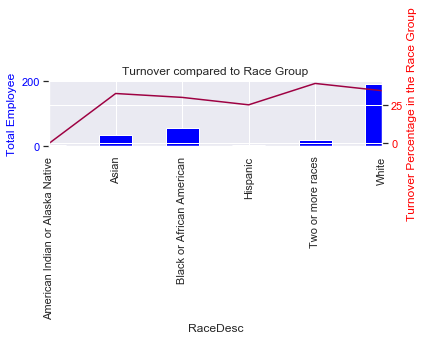

In [187]:
    attribute = emp.groupby('RaceDesc').agg({'Turnover':['size', 'sum', 'mean']})
    attribute.columns = [' '.join(col).strip() for col in attribute.columns.values]
    attribute = attribute.reset_index()
    attribute['Turnover mean'] = attribute['Turnover mean']*100
    attribute.columns = ['RaceDesc', 'Total Employee', 'Turnover Count', 
                       '% of Turnover in the Relevant Group'] 
    
    fig0, ax1 = plt.subplots()
    ax1.set_xlabel("RaceDesc")
    #ax1.set_xticks('AI or AN','Asian','Black','Hispanic','TOMR','White')
    ax1.yaxis.label.set_color('blue')
    ax1.set_ylabel("Total Employee")
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel("Turnover Percentage in the Race Group")
    ax2.yaxis.label.set_color('red')
    
    attribute.set_index(attribute['RaceDesc'], drop=True, inplace=True)
    attribute['Total Employee'].plot(kind = 'bar', stacked = False, ax = ax1, 
                                   colormap = 'winter', rot = 0)
    attribute['% of Turnover in the Relevant Group'].plot(use_index = False, 
                                                         kind = 'line', ax = ax2, colormap='Spectral')
    plt.title('Turnover compared to' + " " + "Race"  + " " + "Group")
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.setp(ax1.get_xticklabels(), rotation=90)   
    fig0.tight_layout()
    plt.show()

##### Work Status Vs. Turnover #####

In [188]:
# Work Status Group & Turnover Table
table_attr('CitizenDesc')

,CitizenDesc,Total Employee,Turnover Count,% of Turnover in the Relevant Group,% of Turnover at Dental Magic
0,Eligible NonCitizen,12,5,41.666667,4.901961
1,Non-Citizen,4,3,75.000000,2.941176
2,US Citizen,294,94,31.972789,92.156863


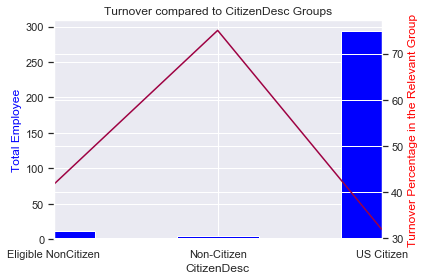

In [189]:
# Turnover Compared to Work Status Group Graph
graph_attr('CitizenDesc')

##### Pie Chart - Inactive Employees #####

In [190]:
# the - (minus) in front of df serves as not in command
term = df[-df['Employment Status'].isin(['Active','Future Start'])] 
active = df[df['Employment Status'].isin(['Active','Future Start'])] 
employment_status = term.groupby(by='Employment Status').size().sort_values(ascending=False)
print(employment_status)

Employment Status
Voluntarily Terminated    88
Terminated for Cause      14
Leave of Absence          14
dtype: int64


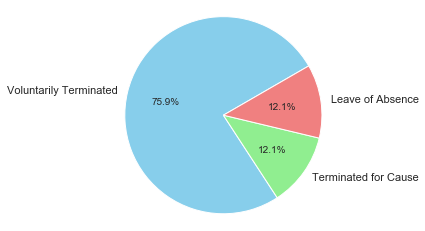

In [191]:
labels = 'Voluntarily Terminated', 'Terminated for Cause', 'Leave of Absence'
colors = ['skyblue', 'lightgreen', 'lightcoral']
sizes = employment_status
plt.pie(sizes,               
        labels=labels,      
        colors=colors,      
        autopct='%1.1f%%',  
        startangle=30       
        )

plt.axis('equal')

plt.show()

##### Sub Plots - Age Vs. Gender Vs. Turnover #####

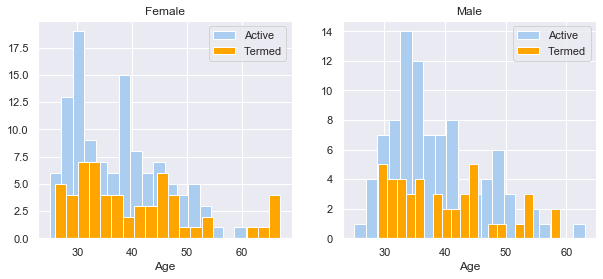

In [192]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = df[df['Sex']=='Female']
ax1.hist(women[women['Turnover']==0].Age, bins=20, label = "Active", color = '#abcdef')
ax1.hist(women[women['Turnover']==1].Age, bins=20, label = "Termed", color = 'Orange')
ax1.set_title('Female')
ax1.xaxis.set_label_text("Age")
ax1.legend()

men = df[df['Sex']=='Male']
ax2.hist(men[men['Turnover']==0].Age, bins=20, label = "Active", color = '#abcdef')
ax2.hist(men[men['Turnover']==1].Age, bins=20, label = "Termed", color = 'Orange')
ax2.set_title('Male')
ax2.xaxis.set_label_text("Age")
ax2.legend()
plt.show()



##### Stacked Bar Chart - Department Vs. Marital Status #####

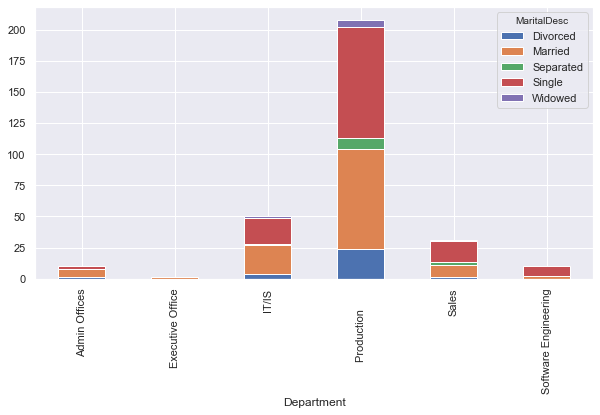

In [193]:
#Margins dictate whether to include grand totals in the plot. Always use False
stacked_table = pd.crosstab(emp.Department, emp.MaritalDesc, margins=False)
stacked_table.plot(kind="bar", figsize=(10,5), stacked=True)
plt.show()

### Final Thoughts ###
***
With all of this information and analysis, here are some of the findings and interpreation of the Dental Magic employees:
 1. There are **310 employee observations and 23 features** (208 active and 102 terminated). The company has a turnover of 33%.
 2. Based on statistical analysis there is some significant difference between the **days employed vs. turnover**. Employees who were employed more than 2 years stayed with the company.
 3. Employees with **low to medium salaries** are the bulk of employee turnover. **Pay Rate between \\$10 - \\$25 composed of 66% Turnover.**
 4. Employees in **25-36 Age group** had highest turnover compared to other age groups.
 5. The Production department had highest employee turnover of 82% and the Executive Office had no turnover.
 
### Future Research Considerations ###
 
As stated earlier this report excludes the last 2 steps in the the OSEMN approach - Model and Interpret. We can certainly explore these steps in the near future to:
- Model the data to give us our predictive power on whether an employee will leave. 
- Interpreting the data with all the results and analysis:
    - What conclusions are made? What factors contributed the most to employee turnover? 
    - Did employees with high salary (above the pay range) who were not promoted leave the company? If so, could this be a signal that we're not developing people or providing enough opportunities? What corrective measures or strategic initiatives, should be taken to prevent high performing employees from leaving the company?
 
By modeling and interpreting the data, we can improve company's performance by creating an engaged workforce and reduce the high-cost of employee turnover.


#### References: ####

Statiscal Concepts: https://www.youtube.com/user/BCFoltz/playlists

OSEMN: https://towardsdatascience.com/5-steps-of-a-data-science-project-lifecycle-26c50372b492

Data Science Pipeline: https://www.linkedin.com/pulse/life-data-science-osemn-randy-lao/

Data Set: https://www.kaggle.com/rhuebner/human-resources-data-set

Seaborn: https://seaborn.pydata.org/tutorial/categorical.html